In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
from torchvision import models as mods
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
from sklearn.covariance import LedoitWolf, MinCovDet

from torchvision.transforms import transforms

from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.random_projection import SparseRandomProjection

import torch
import torch.nn as nn

inv_norm = MVTEC().inv_normalize

from meanshift import *

np.random.seed(252525)
torch.manual_seed(252525)

MVTEC_PATH="../../../../nas-files/mvtec"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
MVTEC.CLASSES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['bottle',
 'carpet',
 'leather',
 'pill',
 'tile',
 'wood',
 'cable',
 'grid',
 'toothbrush',
 'zipper',
 'capsule',
 'hazelnut',
 'metal_nut',
 'screw',
 'transistor']

# Merge Anomaly maps

In [28]:
s = 3*224

IM = np.zeros((4*s, 4*s, 3))
print(IM.shape)

im = plt.imread("./anomalymaps/anomap_0.png")
IM[(0*s):(0*s)+s, (0*s):(0*s)+s]= im[:s, :s, :3]

for i, anomap in enumerate([f for f in os.listdir("anomalymaps") if "anomap" in f]):
    im = plt.imread("./anomalymaps/" + anomap)

    i = i + 1
    x = i % 4
    y = i // 4

    print(i, im.shape, x, y, (x*s)+s, (y*s)+s, s, anomap)

    IM[(x*s):(x*s)+s, (y*s):(y*s)+s]= im[:s, :s, :3]

plt.imsave("anomalymaps/full.png", IM)

(2688, 2688, 3)
1 (1365, 2273, 4) 1 0 1344 672 672 anomap_7.png
2 (2046, 2273, 4) 2 0 2016 672 672 anomap_1.png
3 (2273, 2273, 4) 3 0 2688 672 672 anomap_6.png
4 (684, 2273, 4) 0 1 672 1344 672 anomap_8.png
5 (2046, 2273, 4) 1 1 1344 1344 672 anomap_4.png
6 (3408, 2273, 4) 2 1 2016 1344 672 anomap_3.png
7 (2500, 2273, 4) 3 1 2688 1344 672 anomap_10.png
8 (1592, 2273, 4) 0 2 672 2016 672 anomap_11.png
9 (1365, 2273, 4) 1 2 1344 2016 672 anomap_5.png
10 (911, 2273, 4) 2 2 2016 2016 672 anomap_14.png
11 (1592, 2273, 4) 3 2 2688 2016 672 anomap_0.png
12 (2727, 2273, 4) 0 3 672 2688 672 anomap_9.png
13 (2273, 2273, 4) 1 3 1344 2688 672 anomap_12.png
14 (2727, 2273, 4) 2 3 2016 2688 672 anomap_13.png
15 (2273, 2273, 4) 3 3 2688 2688 672 anomap_2.png


# Create Video

In [16]:
bs = 50
p = 5 # fallback patch_size
s = 1 # stride

net = mods.efficientnet_b4(pretrained=True).features
net = net.to(device)
net.eval()

for clazz in [14]:
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False,
                                                     MVTEC_PATH=MVTEC_PATH )
    
    X_test_images = X_test_

    X = concat_features(X_, net, layers=[5,6], fmap_pool=False)
    X_valid = concat_features(X_valid_, net, layers=[5,6], fmap_pool=False)
    X_test = concat_features(X_test_, net, layers=[5,6], fmap_pool=False)

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    t = X.shape[2] # tile_size
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    for i,j in enumerate(range(1, len(X), 5)):
    
        model = SFA(shape=(c, t, t), 
                        BSZ=(p, p), 
                        stride=s, 
                        n_components="q9999",
                        remove_components=0,
                        max_components=5000,
                        min_components=10,
                        mode="ta")

        model.fit(X[:j], 1, bs=5000, lr=1e-3, logging=-10)

        #auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
        auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
        #auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
        #auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
        #auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
        #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

        #df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
        #                  columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 

        map_i, map_o = local_mean_shift(model, X, X_valid, X_test, size=2)
        anomaly_map = make_anomaly_map(map_i, map_o)[1]
        anomaly_map = anomaly_map + X_test_images
        

        im_test  = torchvision.utils.make_grid(torch.from_numpy(anomaly_map), nrow=10, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 )

        n_rows_test = len(X_test_images)//10
        n_cols_train = 1 + len(X_)//n_rows_test
        if j < n_cols_train:
            trn = np.concatenate([X_[:j], np.zeros_like(X_[:1]).repeat(n_cols_train - j, axis=0)], axis=0)
        else:
            trn = X_[:j]
        im_train = torchvision.utils.make_grid(torch.from_numpy(trn), nrow=n_cols_train, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 )

        margin = 100
        im_train_ = np.zeros((3, im_test.shape[1], im_train.shape[2] + margin ))
        im_train_[:, :im_train.shape[1], margin:margin+im_train.shape[2]] = im_train

        f = plt.figure(figsize=(15,5)) #figure with correct aspect ratio
        ax = plt.axes((0,0,1,1)) #axes over whole figure
        ax.imshow(np.concatenate([im_test, im_train_], axis=2).transpose(1,2,0))
        x,y = im_test.shape[2] + im_train_.shape[2] - 550, im_train_.shape[1] - 100
        ax.text(x,y, f"AUC = {auc_l:.2f}", bbox=dict(fill="white", edgecolor='red', linewidth=2), size="medium")
        ax.axis('off')
        _ = f.savefig(f"im_{clazz}_{i:03d}.png",dpi=300)

KeyboardInterrupt: 

In [14]:
!ffmpeg -r 2 -i im_13_%3d.png -c:v libx264 -vf fps=1 -pix_fmt yuv420p out.mp4

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ios/anaconda3/envs/pytorch3 --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    

# Anomaly Map CIFAR10

In [41]:
log = []
p = 1
n = 100000
P = 28
A = 32

for netname in ["eff", "vitb16", "raw", "res", "vgg"]:
    
    s = 4 if netname == "vitb16" else 2
    L = 7 if netname == "vitb16" else 5
    blocks = [L, L+1] if netname == "vgg" or  netname == "eff" else [L]
    
    r = int( (A - P)/s + 1 )

    for run in range(1):

        if netname != "raw":
            net, layer_map = get_fmap(netname)
            net = net.to(device)
            net = net.eval()


        for clazz in range(0, 10):

            if netname == "raw":
                X, X_valid, X_test = Cifar10_OneClass(train_classes=[clazz], balance=False, fold=run, download=True)[0]
                X, X_valid, X_test,  mean, std = preprocess(X, X_valid, X_test)
            else:
                transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])
                X, X_valid, X_test = Cifar10_OneClass(train_classes=[clazz], balance=False, fold=run, download=True)[0]

            X, X_valid, X_test = asreshape(X, X_valid, X_test, shape=(3, 32, 32))
            X_test_images = X_test.copy()

            if netname == "raw":
                net, layer_map = get_pca(X, 0.9, P, s)
                net = net.to(device)
                net = net.eval()

            if netname == "vitb16":
                X = patches_to_feature_space_vit(X, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                X_valid = patches_to_feature_space_vit(X_valid, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                X_test = patches_to_feature_space_vit(X_test, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
            else:
                X = patches_to_feature_space(X, net, P, s, blocks=blocks, layer_map=layer_map, debug=True)
                X_valid = patches_to_feature_space(X_valid, net, P, s, blocks=blocks, layer_map=layer_map)
                X_test = patches_to_feature_space(X_test, net, P, s, blocks=blocks, layer_map=layer_map)

            print(X.shape)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r, reduce="None")
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r, reduce="None")
            
            break
        break
    break
s_in.shape

Files already downloaded and verified
Files already downloaded and verified
Fmap: (45000, 272, 2, 2)
(5000, 1088, 3, 3)


(1000, 3, 3)

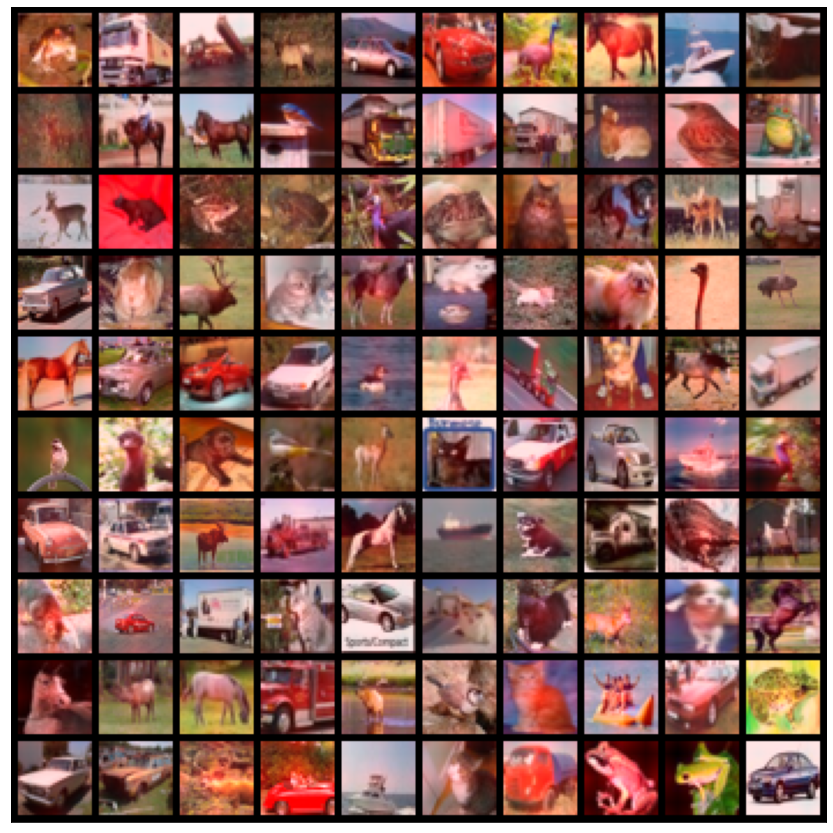

In [50]:
plt.rcParams["figure.figsize"] = (15, 15)
anomaly_map = make_anomaly_map(s_in, s_out, p=1, size=(32, 32))[1]
anomaly_map = 1.5*anomaly_map + 0.9*X_test_images
show( torchvision.utils.make_grid(torch.from_numpy(anomaly_map)[:100], nrow=10, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ) )
#plt.imsave(f"./anomalymaps/anomap_cifar10_{clazz}.png", torchvision.utils.make_grid(torch.from_numpy(anomaly_map), nrow=10, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ).numpy().transpose(1,2,0))

# Anomaly Map MVTEC

In [35]:
bs = 50
p = 3 # fallback patch_size
s = 1 # stride

net = mods.efficientnet_b4(pretrained=True).features
net = net.to(device)
net.eval()

for clazz in range(15):
    
    X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

    X_test_images = X_test_
    
    X = concat_features(X_, net, layers=[5,6], fmap_pool=False)
    X_valid = concat_features(X_valid_, net, layers=[5,6], fmap_pool=False)
    X_test = concat_features(X_test_, net, layers=[5,6], fmap_pool=False)

    shapes = (X.shape, X_test.shape, X_valid.shape)
    c = X.shape[1]
    t = X.shape[2] # tile_size
    n = len(X_valid) + len(X_test)
    print(shapes)
    
    model = SFA(shape=(c, t, t), 
                    BSZ=(p, p), 
                    stride=s, 
                    n_components="q9999",
                    remove_components=0,
                    max_components=5000,
                    min_components=100,
                    mode="ta")

    model.fit(X, 1, bs=5000, lr=1e-3, logging=-10)
    
    #auc_g, tg       = auc_global_mean_shift(model, X_valid, X_test)
    #auc_l, tl       = auc_local_mean_shift(model, X, X_valid, X_test, size=2)
    #auc_c, tc, cset = auc_cluster_mean_shift(model, X, X_valid, X_test, True, return_coreset=True)
    #auc_cc, tcc     = auc_cluster_mean_shift(model, X, X_valid, X_test, False, k=len(cset))
    #auc_s, ts       = auc_sources_mean_shift(model, X, X_valid, X_test)
    #auc_cs, tcs     = auc_coreset(X, X_valid, X_test)

    #df = pd.DataFrame(np.asarray([clazz, auc_g, auc_l, auc_c, auc_cc, auc_s, n/tg, n/tl, n/tc, n/tcc, n/ts, p, t, model.model.n_components])[:, None].T, 
    #                  columns=["class", "AUC-g", "AUC-l", "AUC-c", "AUC-cc", "AUC-s", "fps-g", "fps-l", "fps-c", "fps-cc", "fps-s", "p_size", "t", "n_components"]) 
    
    plt.rcParams["figure.figsize"] = (25, 25)
    map_i, map_o = local_mean_shift(model, X, X_valid, X_test, size=2)
    anomaly_map = make_anomaly_map(map_i, map_o)[1]
    anomaly_map = anomaly_map + X_test_images
    # show( torchvision.utils.make_grid(torch.from_numpy(anomaly_map), nrow=10, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ) )
    plt.imsave(f"./anomalymaps/anomap_{clazz}.png", torchvision.utils.make_grid(torch.from_numpy(anomaly_map), nrow=10, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ).numpy().transpose(1,2,0))

((209, 272, 14, 14), (63, 272, 14, 14), (20, 272, 14, 14))
((280, 272, 14, 14), (89, 272, 14, 14), (28, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2366 must be less or equal to the batch number of samples 1152
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


((245, 272, 14, 14), (92, 272, 14, 14), (32, 272, 14, 14))
((267, 272, 14, 14), (141, 272, 14, 14), (26, 272, 14, 14))
((230, 272, 14, 14), (84, 272, 14, 14), (33, 272, 14, 14))
((247, 272, 14, 14), (60, 272, 14, 14), (19, 272, 14, 14))
((224, 272, 14, 14), (92, 272, 14, 14), (58, 272, 14, 14))
((264, 272, 14, 14), (57, 272, 14, 14), (21, 272, 14, 14))
((60, 272, 14, 14), (30, 272, 14, 14), (12, 272, 14, 14))
((240, 272, 14, 14), (119, 272, 14, 14), (32, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2262 must be less or equal to the batch number of samples 288
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


((219, 272, 14, 14), (109, 272, 14, 14), (23, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2228 must be less or equal to the batch number of samples 2160
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


((391, 272, 14, 14), (70, 272, 14, 14), (40, 272, 14, 14))
((220, 272, 14, 14), (93, 272, 14, 14), (22, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2387 must be less or equal to the batch number of samples 2304
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


((320, 272, 14, 14), (119, 272, 14, 14), (41, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2355 must be less or equal to the batch number of samples 2016
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


((213, 272, 14, 14), (40, 272, 14, 14), (60, 272, 14, 14))


/home/matthias/Desktop/workspace/fasterica/hugeica/nn/Layer_PCA.py:13: UserWarning: Skipping backward(). n_components=2381 must be less or equal to the batch number of samples 1296
  warnings.warn(f"Skipping backward(). n_components={n_components_} must be less or equal to the batch number of samples {len(inpt)}")


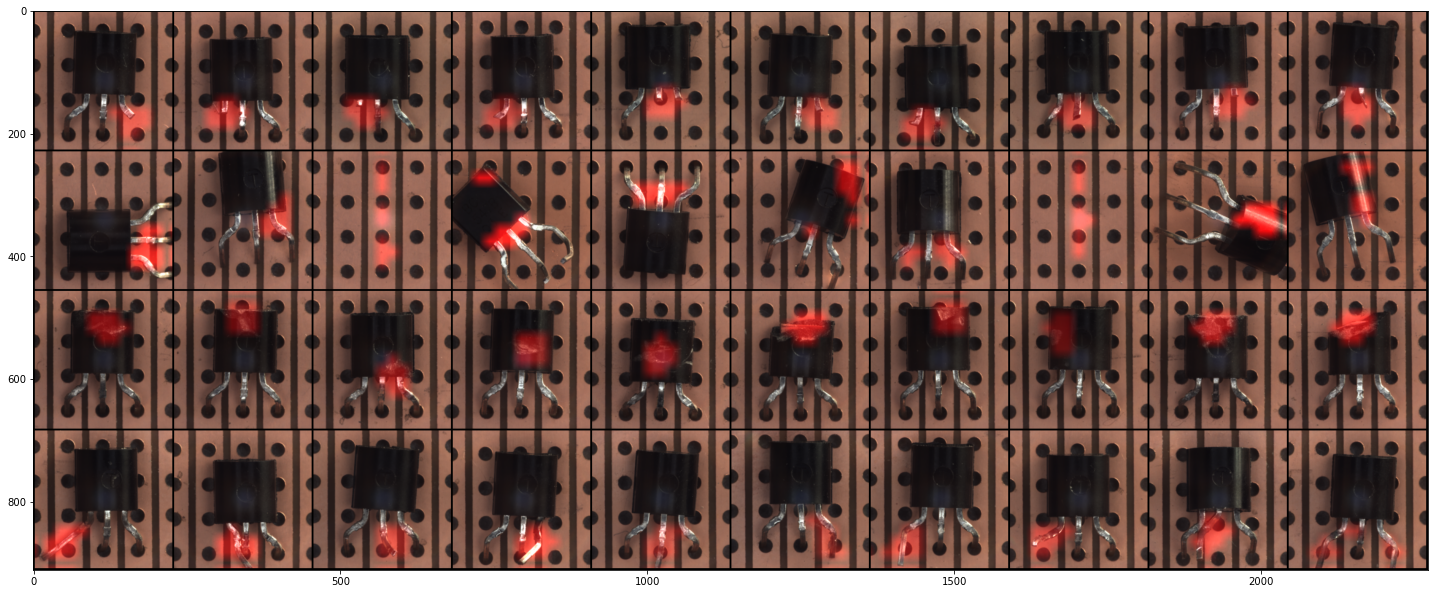

In [34]:
anomaly_map = make_anomaly_map(map_i, map_o)[1]
anomaly_map = anomaly_map + X_test_images
# show( torchvision.utils.make_grid(torch.from_numpy(anomaly_map), nrow=10, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ) )
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(anomaly_map), nrow=10, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ).numpy().transpose(1,2,0))

In [15]:
from data.cifar_novelty import *

clazz = 2# 6# 5 # 3

test_classes = [0,1,2,3,4,5,6,7,8,9]
test_classes.remove(clazz)
X_, X_valid_, X_test_ = Cifar10_OneClass(train_classes=[clazz], test_classes=test_classes, z_normalize=False, balance=True, transform=transforms.Compose([transforms.ToTensor()]))[0]

Files already downloaded and verified
Files already downloaded and verified
Cifar10_OneClass(z_normalize=False, train_classes=[2], test_classes=[0, 1, 3, 4, 5, 6, 7, 8, 9], data_train=(5000, 3072), data_test_inliers=(1000, 3072), data_test_outliers=(1000, 3072))


In [53]:
MVTEC.CLASSES

['bottle',
 'carpet',
 'leather',
 'pill',
 'tile',
 'wood',
 'cable',
 'grid',
 'toothbrush',
 'zipper',
 'capsule',
 'hazelnut',
 'metal_nut',
 'screw',
 'transistor']

In [66]:
X_, X_valid_, X_test_, X_labels_, T = dataloader(5, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False)

(-0.5, 1818.5, 1591.5, -0.5)

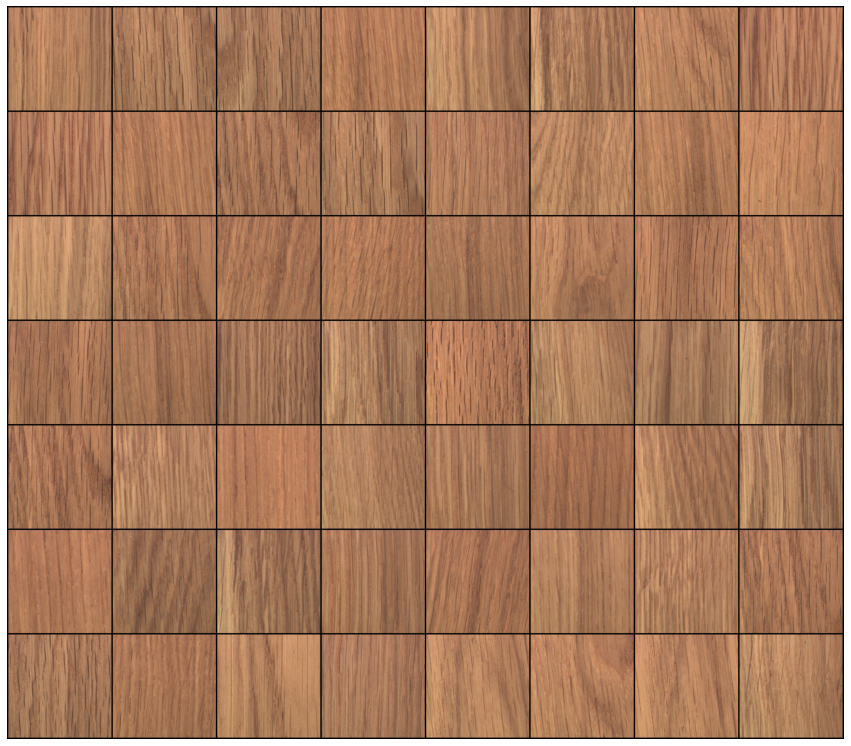

In [74]:
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(X_[:56]), nrow=8, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ).numpy().transpose(1,2,0))
plt.axis("off")

(-0.5, 1818.5, 1591.5, -0.5)

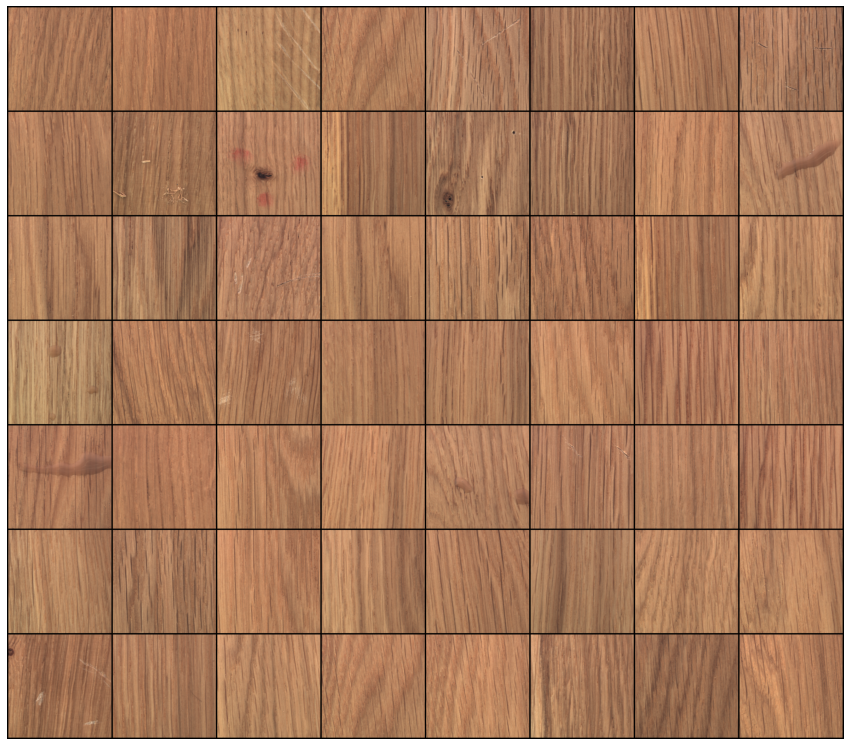

In [77]:
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(np.concatenate([X_test_, X_])[np.random.permutation(len(X_) + len(X_test_))][:56]), nrow=8, normalize=True,  value_range=(0,  1), rscale_each=False , padding=3 ).numpy().transpose(1,2,0))
plt.axis("off")